In [6]:
from pathlib import Path

from rosbags.typesys import get_types_from_msg, register_types


def guess_msgtype(path: Path) -> str:
    """Guess message type name from path."""
    name = path.relative_to(path.parents[2]).with_suffix('')
    if 'msg' not in name.parts:
        name = name.parent / 'msg' / name.name
    return str(name)


add_types = {}

for pathstr in [
    '/home/william/ros2_ws/src/theodolite_node_msgs/msg/TheodoliteCoordsStamped.msg',
]:
    msgpath = Path(pathstr)
    msgdef = msgpath.read_text(encoding='utf-8')
    add_types.update(get_types_from_msg(msgdef, guess_msgtype(msgpath)))

register_types(add_types)


In [13]:
import numpy as np
import csv
import random
import math
from numpy import linalg
import sys
# import rosbag
import rosbags
from rosbags.rosbag1 import Reader
from rosbags.serde import deserialize_cdr, ros1_to_cdr
from nav_msgs.msg import Odometry
from sensor_msgs.msg import Imu
from geometry_msgs.msg import Vector3Stamped
from sensor_msgs.msg import Imu
from std_msgs.msg import Float64MultiArray
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation as R_scipy
from scipy.spatial.transform import Rotation as R
from scipy import interpolate
#from theodolite_node_msgs.msg import *
#from theodolite_node_msgs.msg import TheodoliteCoordsStamped
from std_msgs.msg import Header
# from bagpy import bagreader
from pathlib import PurePath
# import scripts.theodolite_function as tfu
import matplotlib.pyplot as plt



class TheodoliteCoordsStamped:
	def __init__(self, header, theodolite_time, theodolite_id, status, azimuth, elevation, distance):
		self.header = header
		self.theodolite_time = theodolite_time
		self.theodolite_id = theodolite_id
		self.status = status
		self.azimuth = azimuth
		self.elevation = elevation
		self.distance = distance

class TheodoliteTimeCorrection:
	def __init__(self, header, theodolite_id, estimated_time_offset):
		self.header = header
		self.theodolite_id = theodolite_id
		self.estimated_time_offset = estimated_time_offset  
        
def second_nsecond(secs, nsecs):
	#if(nsecs < )
	return secs+nsecs*10**(-9)

def give_points(d, ha, va, param):
    d = d + 0.01 # add 10mm because measurements done by raspi
    if(param ==1):
        x=d*math.cos((90-ha)*np.pi/180)*math.sin(va*np.pi/180)
        y=d*math.sin((90-ha)*np.pi/180)*math.sin(va*np.pi/180)
        z=d*math.cos(va*np.pi/180)
    if(param ==2):
        x=d*math.cos(np.pi/2-ha)*math.sin(va)
        y=d*math.sin(np.pi/2-ha)*math.sin(va)
        z=d*math.cos(va)
    return np.array([x, y, z, 1],dtype=np.float64)

def add_point(d, ha, va, points, param):
	points.append(give_points(d, ha, va, param))

In [14]:
def read_rosbag_theodolite_without_tf_raw_data(file):
    with Reader(file) as bag:
        time_trimble_1 = []
        time_trimble_2 = []
        time_trimble_3 = []
        distance_1 = []
        distance_2 = []
        distance_3 = []
        azimuth_1 = []
        azimuth_2 = []
        azimuth_3 = []
        elevation_1 = []
        elevation_2 = []
        elevation_3 = []
        trajectory_trimble_1 = []
        trajectory_trimble_2 = []
        trajectory_trimble_3 = []
        check_double_1 = 0
        check_double_2 = 0
        check_double_3 = 0
        # Variable for counting number of data and number of mistakes
        it = np.array([0,0,0])
        bad_measures = 0
        #Read topic of trimble
        for connection, timestamp, rawdata in bag.messages():
            if connection.topic == '/theodolite_master/theodolite_data':
                # print(connection)
                # print(timestamp)
                # print(rawdata)
                msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
                marker = TheodoliteCoordsStamped(msg.header, msg.theodolite_time, msg.theodolite_id, msg.status, msg.azimuth, msg.elevation, msg.distance)
                timestamp = second_nsecond(marker.header.stamp.sec, marker.header.stamp.nanosec)
                if(marker.status == 0): # If theodolite can see the prism, or no mistake in the measurement
                    # Find number of theodolite
                    if(marker.theodolite_id==1):
                        if (check_double_1 != timestamp):
                            add_point(marker.distance, marker.azimuth, marker.elevation, trajectory_trimble_1, 2)
                            time_trimble_1.append(timestamp)
                            distance_1.append(marker.distance)
                            azimuth_1.append(marker.azimuth)
                            elevation_1.append(marker.elevation)
                            it[0]+=1
                            check_double_1 = timestamp
                    if(marker.theodolite_id==2):
                        if (check_double_2 != timestamp):
                            add_point(marker.distance, marker.azimuth, marker.elevation, trajectory_trimble_2, 2)
                            time_trimble_2.append(timestamp)
                            distance_2.append(marker.distance)
                            azimuth_2.append(marker.azimuth)
                            elevation_2.append(marker.elevation)
                            it[1]+=1
                            check_double_2 = timestamp
                    if(marker.theodolite_id==3):
                        if (check_double_3 != timestamp):
                            add_point(marker.distance, marker.azimuth, marker.elevation, trajectory_trimble_3, 2)
                            time_trimble_3.append(timestamp)
                            distance_3.append(marker.distance)
                            azimuth_3.append(marker.azimuth)
                            elevation_3.append(marker.elevation)
                            it[2]+=1
                            check_double_3 = timestamp
                # Count mistakes
                if(marker.status != 0):
                    bad_measures+=1
    # Print number of data for each theodolite and the total number of mistakes
    print("Number of data for theodolites:", it)
    print("Bad measures:", bad_measures)

    time_trimble_1 = np.array(time_trimble_1)
    time_trimble_2 = np.array(time_trimble_2)
    time_trimble_3 = np.array(time_trimble_3)
    trajectory_trimble_1 = np.array(trajectory_trimble_1).T
    trajectory_trimble_2 = np.array(trajectory_trimble_2).T
    trajectory_trimble_3 = np.array(trajectory_trimble_3).T
    distance_1 = np.array(distance_1)
    distance_2 = np.array(distance_2)
    distance_3 = np.array(distance_3)
    azimuth_1 = np.array(azimuth_1)
    azimuth_2 = np.array(azimuth_2)
    azimuth_3 = np.array(azimuth_3)
    elevation_1 = np.array(elevation_1)
    elevation_2 = np.array(elevation_2)
    elevation_3 = np.array(elevation_3)

    return time_trimble_1, time_trimble_2, time_trimble_3, trajectory_trimble_1, trajectory_trimble_2, trajectory_trimble_3, distance_1, distance_2, distance_3, azimuth_1, azimuth_2, azimuth_3, elevation_1, elevation_2, elevation_3

In [15]:
fname = '/media/william/T7/theodolite_bags/20220711_TS/2022-07-11-15-50-00.bag'
t1, t2, t3, tp1, tp2, tp3, d1, d2, d3, a1, a2, a3, e1, e2, e3 = read_rosbag_theodolite_without_tf_raw_data(fname)
print(len(t1),len(t2),len(t3))

Number of data for theodolites: [3529 3342 3320]
Bad measures: 777
3529 3342 3320


In [16]:
def plot_trajectories_prism(number_data, trimble_1, trimble_2, trimble_3, T_1_rasp, T_12_rasp, T_13_rasp, plot_3d, save_pdf, file_pdf, plot_equal):
	fig = plt.figure(figsize=(10,7))
	if(plot_3d == 1):
		ax = fig.add_subplot(111, projection='3d')
		# Calibration points in theodolite 1 frame
		#ax.scatter(x1, y1, z1, c='black', marker='o', s=200, label="Markers frame 1")
		# Theodolite positions in theodolite 1 frame
		ax.scatter(T_1_rasp[0,3], T_1_rasp[1,3], T_1_rasp[2,3], c='red', marker='*', s=200, label="Theodolite 1")
		if(number_data>1):
			ax.scatter(T_12_rasp[0,3], T_12_rasp[1,3], T_12_rasp[2,3], c='blue', marker='*', s=200, label="Theodolite 2")
		if(number_data>2):
			ax.scatter(T_13_rasp[0,3], T_13_rasp[1,3], T_13_rasp[2,3], c='green', marker='*', s=200, label="Theodolite 3")
		# Prisms trajectories in theodolite 1 frame
		ax.scatter(trimble_1[0], trimble_1[1], trimble_1[2], c='r', marker='.', label="Prism with rasp 1")
		if(number_data>1):
			ax.scatter(trimble_2[0], trimble_2[1], trimble_2[2], c='b', marker='.', label="Prism with rasp 2")
		if(number_data>2):
			ax.scatter(trimble_3[0], trimble_3[1], trimble_3[2], c='g', marker='.', label="Prism with rasp 3")
		ax.set_xlabel('x[m]')
		ax.set_ylabel('y[m]')
		ax.set_zlabel('Z Label')
		ax.legend(loc='best') 
		if(plot_equal==1):
			ax.set_aspect('equal')
	if(plot_3d == 0):
		ax = fig.add_subplot(111)
		# Theodolite positions in theodolite 1 frame
		ax.scatter(T_1_rasp[0,3], T_1_rasp[1,3], c='red', marker='*', s=200, label="Theodolite 1")
		if(number_data>1):
			ax.scatter(T_12_rasp[0,3], T_12_rasp[1,3], c='blue', marker='*', s=200, label="Theodolite 2")
		if(number_data>2):
			ax.scatter(T_13_rasp[0,3], T_13_rasp[1,3], c='green', marker='*', s=200, label="Theodolite 3")
		# Prisms trajectories in theodolite 1 frame
		ax.scatter(trimble_1[0], trimble_1[1], c='r', marker='.', label="Prism with rasp 1")
		if(number_data>1):
			ax.scatter(trimble_2[0], trimble_2[1], c='b', marker='.', label="Prism with rasp 2")
		if(number_data>2):
			ax.scatter(trimble_3[0], trimble_3[1], c='g', marker='.', label="Prism with rasp 3")
		ax.set_xlabel('x[m]')
		ax.set_ylabel('y[m]')
		ax.legend(loc='best')
		if(plot_equal==1):
			ax.set_aspect('equal')
	plt.show()
	#plt.gca().set_aspect('equal', adjustable='box')
	fig.tight_layout()
	if save_pdf == 1:
		if plot_3d == 1:
			fig.savefig(file_pdf, bbox_inches='tight')
		else:
			fig.savefig(file_pdf, bbox_inches='tight')


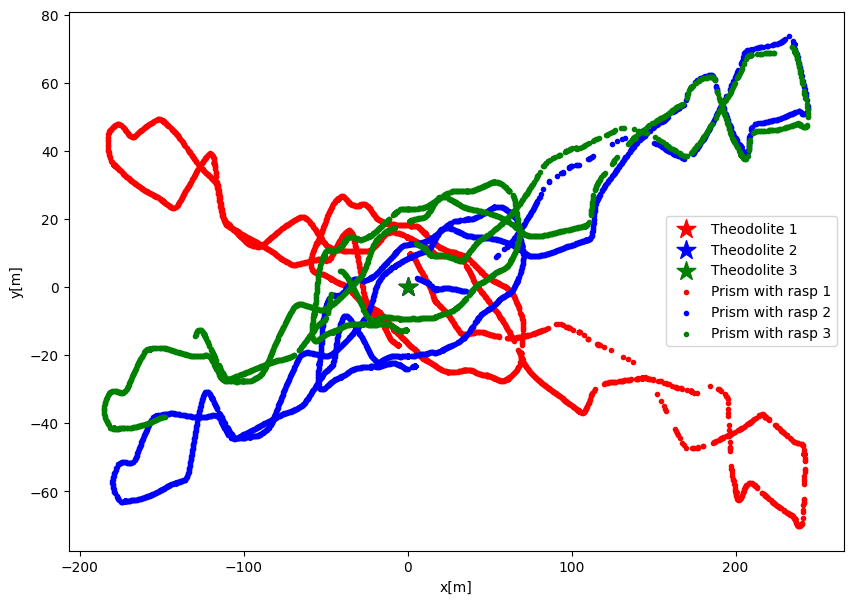

In [17]:
T1 = np.identity(4)
T12 = np.identity(4)
T13 = np.identity(4)
plot_trajectories_prism(3, tp1, tp2, tp3, T1, T12, T13, 0, 0, "", 0)
